# Análisis Espacial de Eventos de Inundación Pluviales en Medellín
Este cuaderno realiza un análisis de los 441 eventos de inundación (Flood causados por Rainfall). Calcula KDE, NND y clustering, y los representa sobre un mapa de fondo.
Se corrige la propagación de atributos entre CRS originales y WebMercator.

## 1. Importación de librerías

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
from sklearn.neighbors import KernelDensity, NearestNeighbors
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import contextily as ctx
from shapely.geometry import Polygon
from scipy.spatial import distance_matrix
from scipy.interpolate import griddata
import matplotlib.ticker as ticker

## 2. Carga y preparación de datos

In [3]:
# Ruta al shapefile
shapefile_path = "D:\Semestre 2025-1\Analisis Geoespacial\SHP\Inventario_inundaciones_lluvias_medellin.shp"

# Cargar datos
gdf = gpd.read_file(shapefile_path)

# Asignar CRS si no existe
print("CRS original:", gdf.crs)
if gdf.crs is None:
    gdf.set_crs(epsg=9377, inplace=True, allow_override=True)

# Crear versión WebMercator para basemap
gdf_web = gdf.to_crs(epsg=3857)


<>:2: SyntaxWarning: invalid escape sequence '\S'
<>:2: SyntaxWarning: invalid escape sequence '\S'
C:\Users\Usuario\AppData\Local\Temp\ipykernel_8172\174252538.py:2: SyntaxWarning: invalid escape sequence '\S'
  shapefile_path = "D:\Semestre 2025-1\Analisis Geoespacial\SHP\Inventario_inundaciones_lluvias_medellin.shp"


CRS original: EPSG:9377


## 3. Extracción de coordenadas métricas

In [4]:
coords = np.vstack([gdf.geometry.x, gdf.geometry.y]).T
coords[:5]


array([[4716193.77103549, 2249044.18543133],
       [4718274.5780644 , 2252102.08147138],
       [4716193.77103549, 2249044.18543133],
       [4716193.77103549, 2249044.18543133],
       [4716193.77103549, 2249044.18543133]])

## 4. Densidad de Kernel (KDE)

In [5]:
# 4. Estimación de Densidad de Kernel (KDE)
bandwidth = 800
kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
kde.fit(coords)

# Densidad original (m⁻²)
gdf['kde_density'] = np.exp(kde.score_samples(coords))
print("KDE stats - min, mean, max:", 
      gdf['kde_density'].min(), 
      gdf['kde_density'].mean(), 
      gdf['kde_density'].max())

# NUEVO: convertir a eventos por km²
gdf['kde_per_10km2'] = gdf['kde_density'] * 1e7
print("=== KDE en eventos/10km² ===")
print(gdf['kde_per_10km2'].describe())

KDE stats - min, mean, max: 1.0171302905610574e-09 1.7497796299268936e-08 4.777981085048567e-08
=== KDE en eventos/10km² ===
count    441.000000
mean       0.174978
std        0.144767
min        0.010171
25%        0.079299
50%        0.128951
75%        0.188008
max        0.477798
Name: kde_per_10km2, dtype: float64


## 5. Distancia al Vecino Más Cercano (NND)

In [6]:
# 1) Añadir columnas de coordenadas
gdf_web['x'] = gdf_web.geometry.x
gdf_web['y'] = gdf_web.geometry.y

# 2) Crear un GeoDataFrame sin duplicados exactos
gdf_unique = gdf_web.drop_duplicates(subset=['x','y']).copy()

# 3) Preparar array de coordenadas únicas
coords_u = np.vstack([gdf_unique['x'], gdf_unique['y']]).T

# 4) (Opcional) Jitter muy pequeño para romper empates residuales
coords_u_j = coords_u + np.random.normal(scale=0.01, size=coords_u.shape)

# 5) Ajustar NearestNeighbors pidiendo 6 vecinos (propio + 5 reales)
nn = NearestNeighbors(n_neighbors=6).fit(coords_u_j)

# 6) Calcular distancias
dist_u, _ = nn.kneighbors(coords_u_j)

# 7) Guardar distancia al 5.º vecino
gdf_unique['nnd5'] = dist_u[:, 5]

# 8) Mapear ese valor de vuelta a todos los registros originales
gdf_web = gdf_web.merge(
    gdf_unique[['x','y','nnd5']],
    on=['x','y'],
    how='left'
)

# 9) Estadísticas finales
print("NND5 stats (m) — min, mean, max:",
      gdf_web['nnd5'].min(),
      gdf_web['nnd5'].mean(),
      gdf_web['nnd5'].max())
print("\n=== Estadísticas de NND5 ===")
print(gdf_web['nnd5'].describe())

NND5 stats (m) — min, mean, max: 538.034298499121 1011.3458230892608 2417.0262395842074

=== Estadísticas de NND5 ===
count     441.000000
mean     1011.345823
std       301.658334
min       538.034298
25%       765.757306
50%       934.780426
75%      1178.755464
max      2417.026240
Name: nnd5, dtype: float64


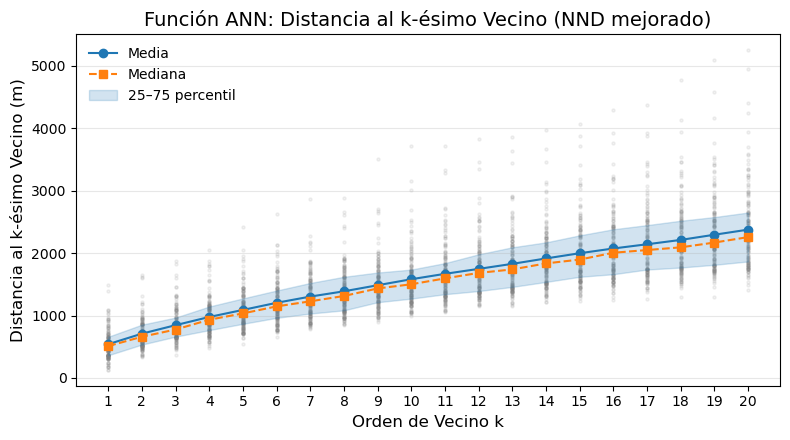

In [7]:
# 1) Eliminar duplicados exactos para no tener distancias cero en k=1
gdf_unique = gdf_web.drop_duplicates(subset='geometry').copy()

# 2) Prepara coordenadas únicas y añade jitter minúsculo (0.01 m)
coords_u = np.vstack([gdf_unique.geometry.x, gdf_unique.geometry.y]).T
coords_u_j = coords_u + np.random.normal(scale=0.01, size=coords_u.shape)

# 3) Configura hasta qué orden de vecinos (incluye el propio)
max_order = 20
nn = NearestNeighbors(n_neighbors=max_order+1).fit(coords_u_j)

# 4) Calcula las distancias
dist_u, _ = nn.kneighbors(coords_u_j)

# 5) Distancias al k-ésimo vecino (descarta la columna 0)
d_k = dist_u[:, 1:]  # shape = (n_unique, max_order)

# 6) Estadísticos por orden de vecino
orders = np.arange(1, max_order+1)
mean_d = d_k.mean(axis=0)
p25, p75 = np.percentile(d_k, [25,75], axis=0)

# 7) Gráfico
fig, ax = plt.subplots(figsize=(8,4.5))

# 7a) Nube de puntos con marker pequeño y muy transparente
for k in orders:
    ax.scatter(
        np.full(d_k.shape[0], k),
        d_k[:, k-1],
        s=5, c='gray', alpha=0.1, marker='o'
    )

# 7b) Media (línea sólida) y mediana (línea discontinua)
median_d = np.percentile(d_k, 50, axis=0)
ax.plot(orders, mean_d, '-o', color='tab:blue', label='Media')
ax.plot(orders, median_d, '--s', color='tab:orange', label='Mediana')

# 7c) Banda IQR
ax.fill_between(orders, p25, p75, color='tab:blue', alpha=0.2, label='25–75 percentil')

# 8) Ajustes finales
ax.set_xlabel('Orden de Vecino k', fontsize=12)
ax.set_ylabel('Distancia al k-ésimo Vecino (m)', fontsize=12)
ax.set_title('Función ANN: Distancia al k-ésimo Vecino (NND mejorado)', fontsize=14)
ax.set_xticks(orders)
ax.legend(frameon=False, fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Clustering con DBSCAN

In [8]:
db = DBSCAN(eps=800, min_samples=5).fit(coords)
gdf['cluster'] = db.labels_
print("Clusters:", len(set(gdf['cluster'])) - (1 if -1 in gdf['cluster'] else 0), "Noise points:", list(gdf['cluster']).count(-1))
print("=== Conteo por Cluster (DBSCAN) ===")
print(gdf['cluster'].value_counts(), "\n")

n_clusters = len([c for c in gdf['cluster'].unique() if c != -1])
n_noise    = (gdf['cluster'] == -1).sum()
print(f"Número de clusters: {n_clusters}")
print(f"Puntos ruido: {n_noise}")

Clusters: 12 Noise points: 38
=== Conteo por Cluster (DBSCAN) ===
cluster
 0     191
 1     116
-1      38
 6      32
 3      16
 2      10
 10     10
 4       7
 8       6
 5       5
 7       5
 9       5
Name: count, dtype: int64 

Número de clusters: 11
Puntos ruido: 38


## 7. Propagar atributos al CRS para mapas de fondo

In [14]:
# Propagar columnas calculadas a la versión WebMercator
for col in ['kde_density', 'cluster']:
    gdf_web[col] = gdf[col].values
# ——— PROPAGA LA NUEVA COLUMNA DE KDE EN KM² ———
gdf_web['kde_per_10km2'] = gdf['kde_per_10km2'].values

## 8. Visualización

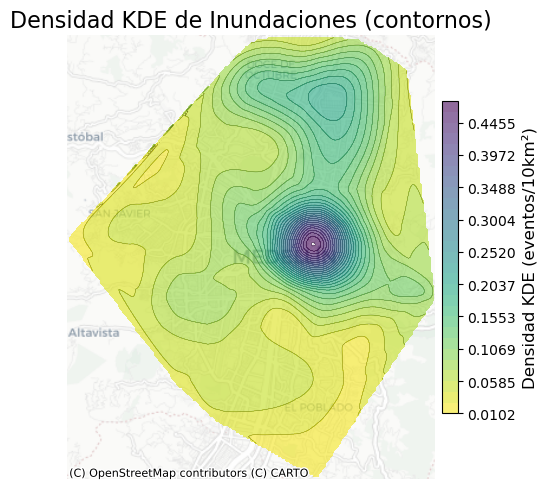

In [10]:
# ——— KDE CON CONTORNOS ———
# 1) Extraer X, Y y densidad real en eventos/10km²
x = gdf_web.geometry.x.values
y = gdf_web.geometry.y.values
vals = gdf_web['kde_per_10km2'].values

# 2) Crear malla regular
xmin, ymin, xmax, ymax = gdf_web.total_bounds
nx, ny = 200, 200
xi = np.linspace(xmin, xmax, nx)
yi = np.linspace(ymin, ymax, ny)
xx, yy = np.meshgrid(xi, yi)

# 3) Interpolar KDE sobre la malla
zi = griddata((x, y), vals, (xx, yy), method='cubic')

# 4) Niveles equiespaciados según tu rango de datos
levels = np.linspace(vals.min(), vals.max(), 30)

# 5) Dibujar contourf + isolíneas
fig, ax = plt.subplots(figsize=(5, 5))
cf = ax.contourf(
    xx, yy, zi,
    levels=levels,
    cmap='viridis_r',
    alpha=0.6
)
ax.contour(
    xx, yy, zi,
    levels=levels,
    colors='k',
    linewidths=0.3,
    alpha=0.5
)

# 6) Colorbar en el mismo fig
cbar = fig.colorbar(cf, ax=ax, fraction=0.04, pad=0.02)
cbar.set_label('Densidad KDE (eventos/10km²)', fontsize=12)
cbar.ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=False))
cbar.ax.yaxis.get_offset_text().set_visible(False)

# 7) Basemap y estilo final
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom=12)
ax.set_title('Densidad KDE de Inundaciones (contornos)', fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()

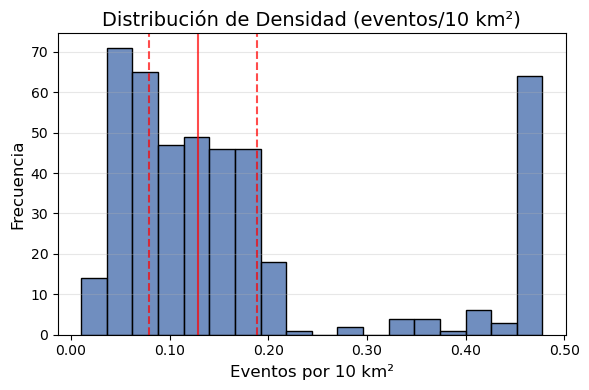

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter

data = gdf['kde_per_10km2']

plt.figure(figsize=(6,4))
sns.histplot(
    data,
    bins=18,                   # menos bins
    # edgecolor=None,            # sin borde negro
    color="#4C72B0",           # color consistente
    alpha=0.8
)
# Líneas de cuartiles
q1, med, q3 = data.quantile([0.25,0.5,0.75])
for q, ls in zip([q1,med,q3], ['--','-','--']):
    plt.axvline(q, color='r', linestyle=ls, alpha=0.7)

plt.title('Distribución de Densidad (eventos/10 km²)', fontsize=14)
plt.xlabel('Eventos por 10 km²', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


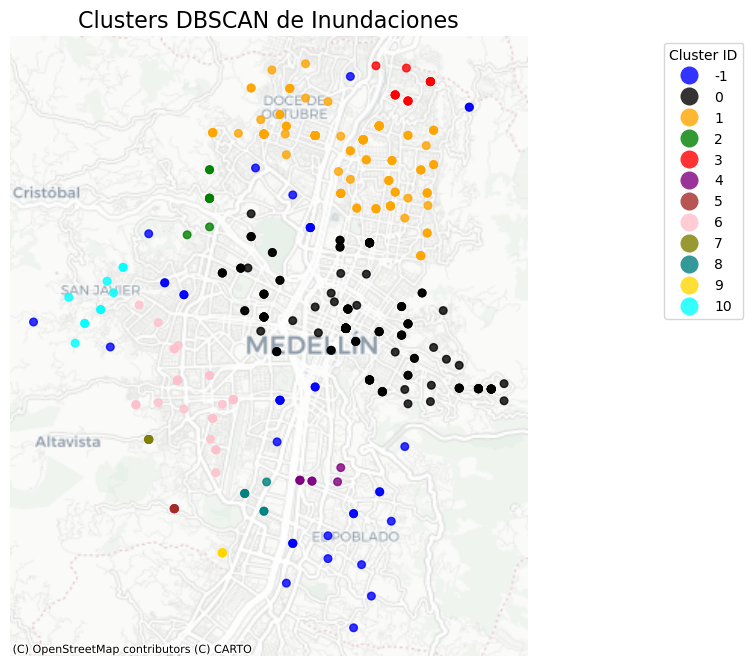

In [12]:
from matplotlib.colors import ListedColormap

# 1) Ordena las categorías de cluster (–1 = ruido, 0, 1, …, 10)
cats = sorted(gdf_web['cluster'].unique())  # p.ej. [-1, 0, 1, 2, …, 10]

# 2) Define una lista de 12 colores bien contrastados,
#    en el mismo orden de `cats`:
#    - Ruido (–1) en gris claro
#    - Cluster 0 en azul oscuro
#    - Clusters 1–8 con colores vivos
#    - Clusters 9 y 10 en tonos únicos
colors = [
    'blue',    # -1 ruido
    'black',         #  0
    'orange',       #  1
    'green',        #  2
    'red',          #  3
    'purple',       #  4
    'brown',        #  5
    'pink',         #  6
    'olive',        #  7
    'teal',         #  8
    'gold',         #  9  <- nuevo color, distingue de 10
    'cyan'          # 10
]

# 3) Crea un colormap “listado” con esos colores
cmap = ListedColormap(colors)

# 4) Dibuja la figura
fig, ax = plt.subplots(figsize=(7, 7))

gdf_web.plot(
    column='cluster',
    categorical=True,
    cmap=cmap,
    legend=True,
    markersize=30,
    alpha=0.8,
    ax=ax,
    legend_kwds={
        'bbox_to_anchor': (1.25, 1),
        'loc': 'upper left',
        'title': 'Cluster ID',
        'markerscale': 1.3
    }
)

# 5) Añade un basemap para contexto
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom=12)

# 6) Ajustes finales
ax.set_title('Clusters DBSCAN de Inundaciones', fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()

## 9. Guardar resultados

In [ ]:
output_path = "inventario_inundaciones_features_updated.shp"
gdf.to_file(output_path)
print(f"Guardado: {output_path}")


## 10. Análisis de Quadrats
Dividimos el área de estudio en una malla de 10×10 celdas y contamos cuántos eventos de inundación caen en cada celda.
El conteo resultante (`quadrat_count`) se añade como una nueva columna al GeoDataFrame y se representa en un mapa coroplético.

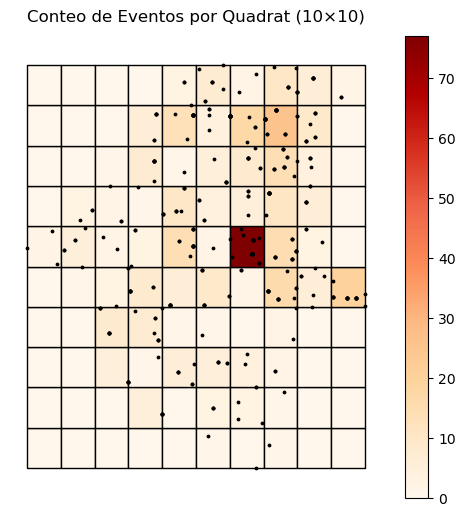

— Estadísticas de quadrat_count —
count    441.000000
mean      21.988662
std       26.062902
min        0.000000
25%        6.000000
50%       11.000000
75%       20.000000
max       77.000000
Name: quadrat_count, dtype: float64


In [48]:
from shapely.geometry import Polygon

# Definir cuadrícula de quadrats (10x10)
xmin, ymin, xmax, ymax = gdf.total_bounds
n_cols, n_rows = 10, 10
dx = (xmax - xmin) / n_cols
dy = (ymax - ymin) / n_rows

# Crear polígonos
quads = []
for i in range(n_cols):
    for j in range(n_rows):
        quads.append(Polygon([
            (xmin + i*dx, ymin + j*dy),
            (xmin + (i+1)*dx, ymin + j*dy),
            (xmin + (i+1)*dx, ymin + (j+1)*dy),
            (xmin + i*dx, ymin + (j+1)*dy)
        ]))
quad_polys = gpd.GeoDataFrame({'geometry': quads}, crs=gdf.crs)

# Contar eventos por quadrat
join = gpd.sjoin(gdf[['geometry']], quad_polys, how='left', predicate='within')
counts = join.groupby('index_right').size().reindex(range(len(quads)), fill_value=0)
quad_polys['count'] = counts.values

# Añadir feature al GeoDataFrame original
gdf['quadrat_count'] = join['index_right'].map(counts).fillna(0).astype(int).values

# Visualizar conteos
fig, ax = plt.subplots(figsize=(6,6))
quad_polys.plot(column='count', cmap='OrRd', edgecolor='black', legend=True, ax=ax)
gdf.plot(ax=ax, color='black', markersize=3)
ax.set_title('Conteo de Eventos por Quadrat (10×10)')
ax.axis('off')
plt.show()
print("— Estadísticas de quadrat_count —")
print(gdf['quadrat_count'].describe())

## 11. Función K de Ripley
Calculamos la función K(d) para evaluar la escala de agrupamiento de los eventos
y comparamos con un patrón aleatorio (CSR) para obtener una banda de confianza del 95%.

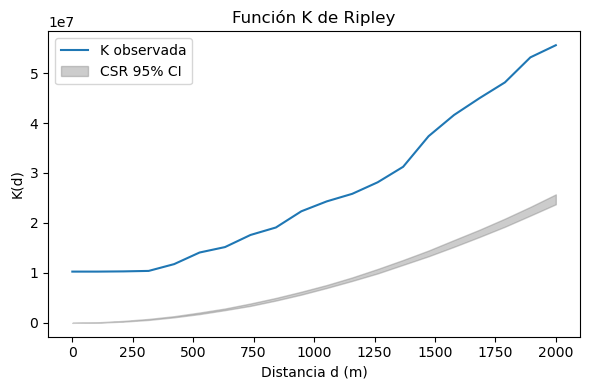

d = 0 m  →  K_obs = 1.03e+07
d = 105 m  →  K_obs = 1.03e+07
d = 211 m  →  K_obs = 1.03e+07
d = 316 m  →  K_obs = 1.04e+07
d = 421 m  →  K_obs = 1.18e+07
d = 526 m  →  K_obs = 1.41e+07
d = 632 m  →  K_obs = 1.52e+07
d = 737 m  →  K_obs = 1.76e+07
d = 842 m  →  K_obs = 1.91e+07
d = 947 m  →  K_obs = 2.23e+07

Primera distancia con clustering significativo (d>0): 105 m


In [13]:
# Preparar patrón puntual
coords = np.vstack([gdf.geometry.x, gdf.geometry.y]).T
n = coords.shape[0]
xmin, ymin, xmax, ymax = gdf.total_bounds
area = 3.76397e8

# Definir distancias
max_dist = 2000
n_d = 20
ds = np.linspace(0, max_dist, n_d)

# Calcular K(d) observado
dist_mat = distance_matrix(coords, coords)
K_obs = []
for d in ds:
    count = np.sum((dist_mat <= d)) - n  # excluir distancia a sí mismo
    K_obs.append(area / (n * (n - 1)) * count)

# Simulaciones CSR
sim_ks = []
for _ in range(99):
    xs = np.random.uniform(xmin, xmax, n)
    ys = np.random.uniform(ymin, ymax, n)
    sim_coords = np.vstack([xs, ys]).T
    sim_dist = distance_matrix(sim_coords, sim_coords)
    k_vals = []
    for d in ds:
        cnt = np.sum((sim_dist <= d)) - n
        k_vals.append(area / (n * (n - 1)) * cnt)
    sim_ks.append(k_vals)
sim_ks = np.array(sim_ks)
k_low = np.percentile(sim_ks, 2.5, axis=0)
k_high = np.percentile(sim_ks, 97.5, axis=0)

# Graficar K(d)
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(ds, K_obs, label='K observada')
ax.fill_between(ds, k_low, k_high, color='gray', alpha=0.4, label='CSR 95% CI')
ax.set_xlabel('Distancia d (m)')
ax.set_ylabel('K(d)')
ax.set_title("Función K de Ripley")
ax.legend()
plt.tight_layout()
plt.show()
# Mostrar los primeros valores de K(d)
for d, k in zip(ds[:10], K_obs[:10]):
    print(f"d = {d:.0f} m  →  K_obs = {k:.2e}")
    
# Encontrar la distancia crítica donde K_obs sale de la banda CSR
# Excluir d=0
mask = (K_obs[1:] > k_high[1:])
if mask.any():
    # Encontramos el primer índice verdadero en mask y sumamos +1 para re-ajustar al índice original
    idx = mask.argmax() + 1
    d_crit = ds[idx]
    print(f"\nPrimera distancia con clustering significativo (d>0): {d_crit:.0f} m")
else:
    print("\nNo hay agregación significativa para d>0 en [0, 2000] m")

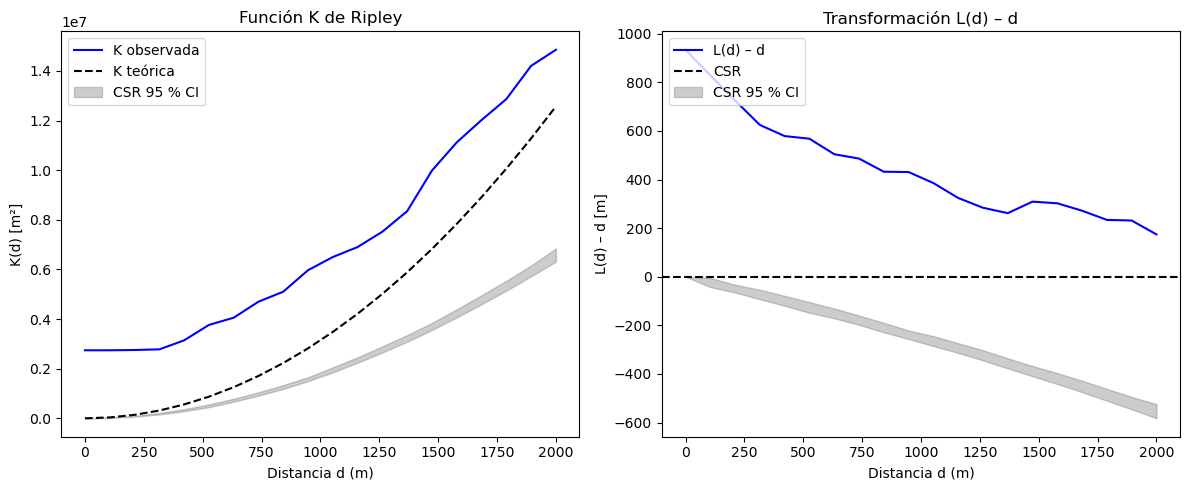

Primera distancia significativa (L(d)–d > 0): 105 m


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
import math

# 1) Preparar datos
coords = np.vstack([gdf.geometry.x, gdf.geometry.y]).T
n = coords.shape[0]
xmin, ymin, xmax, ymax = gdf.total_bounds

# 2) Usar el área real (m²)
area = 100570000

# 3) Definir distancias (0–2000 m en 20 pasos)
max_dist = 2000
n_d = 20
ds = np.linspace(0, max_dist, n_d)

# 4) Calcular K_observada
dist_mat = distance_matrix(coords, coords)
K_obs = []
for d in ds:
    cnt = np.sum(dist_mat <= d) - n      # excluye la diagonal
    K_obs.append(area / (n * (n - 1)) * cnt)
K_obs = np.array(K_obs)

# 5) Simulaciones CSR para envelope (99 réplicas)
sim_ks = []
for _ in range(99):
    xs = np.random.uniform(xmin, xmax, n)
    ys = np.random.uniform(ymin, ymax, n)
    sim = np.vstack([xs, ys]).T
    sim_dm = distance_matrix(sim, sim)
    k_vals = []
    for d in ds:
        cnt = np.sum(sim_dm <= d) - n
        k_vals.append(area / (n * (n - 1)) * cnt)
    sim_ks.append(k_vals)
sim_ks = np.array(sim_ks)
k_low, k_high = np.percentile(sim_ks, 2.5, axis=0), np.percentile(sim_ks, 97.5, axis=0)

# 6) Curva teórica CSR: K_teo(d) = π d²
K_teo = math.pi * ds**2

# 7) Transformación L(d) – d
L_obs     = np.sqrt(K_obs / math.pi)
L_low     = np.sqrt(k_low / math.pi)
L_high    = np.sqrt(k_high / math.pi)
L_minus_d = L_obs - ds
L_low     = L_low - ds
L_high    = L_high - ds

# 8) Graficar K(d) y L(d) – d lado a lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# --- Panel 1: K(d) ---
ax1.plot(ds, K_obs,   label='K observada',    color='blue')
ax1.plot(ds, K_teo,   '--', label='K teórica', color='black')
ax1.fill_between(ds, k_low, k_high, color='gray', alpha=0.4, label='CSR 95 % CI')
ax1.set_xlabel('Distancia d (m)')
ax1.set_ylabel('K(d) [m²]')
ax1.set_title('Función K de Ripley')
ax1.legend(loc='upper left')

# --- Panel 2: L(d) – d ---
ax2.plot(ds, L_minus_d, label='L(d) – d',         color='blue')
ax2.axhline(0,              linestyle='--', color='black', label='CSR')
ax2.fill_between(ds, L_low, L_high, color='gray', alpha=0.4, label='CSR 95 % CI')
ax2.set_xlabel('Distancia d (m)')
ax2.set_ylabel('L(d) – d [m]')
ax2.set_title('Transformación L(d) – d')
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()

# 9) Distancia crítica (cuando L(d) – d > 0 por primera vez)
mask = L_minus_d[1:] > L_high[1:]
if mask.any():
    d_crit = ds[1:][mask][0]
    print(f"Primera distancia significativa (L(d)–d > 0): {d_crit:.0f} m")
else:
    print("No se detecta clustering significativo en [0, 2000] m.")

(-8420446.619600847, -8407349.519720675, 688572.4792852122, 704272.0181035638)

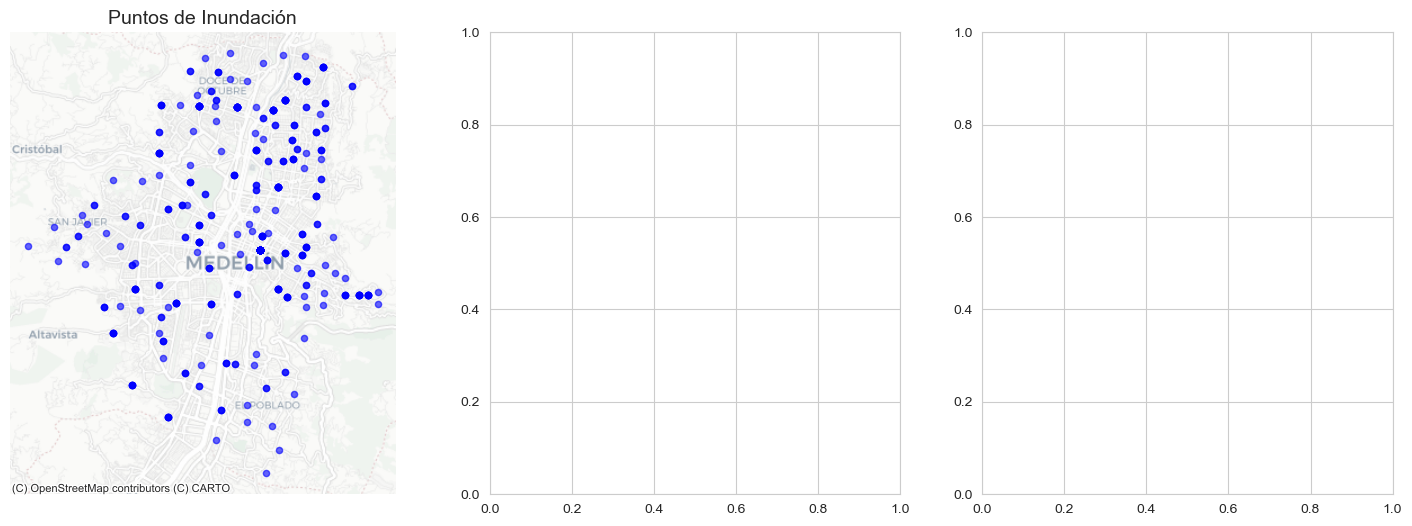

In [60]:
# Asumimos que ya tienes cargados:
# gdf_web con las columnas geometry, kde_per_10km2 (eventos/10km²), cluster

# 1) Prepara la malla para KDE
x = gdf_web.geometry.x.values
y = gdf_web.geometry.y.values
vals = gdf_web['kde_per_10km2'].values

xmin, ymin, xmax, ymax = gdf_web.total_bounds
nx, ny = 200, 200
xi = np.linspace(xmin, xmax, nx)
yi = np.linspace(ymin, ymax, ny)
xx, yy = np.meshgrid(xi, yi)
zi = griddata((x, y), vals, (xx, yy), method='cubic')

# 2) Dibuja la figura de 3 paneles
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 2a) Puntos de inundación originales
gdf_web.plot(
    ax=axes[0],
    color='blue',
    markersize=20,
    alpha=0.6
)
ctx.add_basemap(
    axes[0],
    source=ctx.providers.CartoDB.Positron,
    zoom=12
)
axes[0].set_title('Puntos de Inundación', fontsize=14)
axes[0].axis('off')

